# Model Explainability and Interpretation

## Notebook Overview

In this notebook, we load the final trained model and optimal decision threshold from `03_modeling.ipynb`, and focus on interpreting the model’s predictions using SHAP (SHapley Additive exPlanations).

Our primary goals are to:

- Identify which features most strongly influence the model’s predictions.
- Understand how these influences vary globally and at the individual prediction level.
- Investigate edge cases, including high-risk or borderline predictions.
- Examine how shifting the decision threshold affects model output and interpretation.
- Communicate insights clearly for future model improvement or stakeholder use.

We use **SHAP** to generate both global feature importance plots and local explanations for selected cases. These explanations help verify the model’s logic, uncover patterns related to attrition, and identify actionable insights.

## 1. Load final model, threshold, preprocessed data 

We begin by importing the final version of the trained model, which was exported in `03_modeling.ipynb`, along with the optimal classification threshold identified during threshold tuning.

This allows us to reproduce and interpret the model predictions as they will be used in practice.

To ensure consistency, we reload the same preprocessed dataset used during evaluation. This includes the feature-engineered and encoded features passed into the model.

In [1]:
# Load final model and threshold from disk
import joblib
import json
import pandas as pd

# Correct path to match your actual file name
model = joblib.load("../models/final_model.joblib")

# Load best threshold
with open("../models/best_threshold.json", "r") as f:
    threshold_data = json.load(f)
    print(threshold_data)  # Debugging line, can be deleted after confirming
    best_threshold = threshold_data["best_threshold"]


print(f"Model and best threshold loaded successfully.\nBest Threshold: {best_threshold}")

# Load raw features and target
X = pd.read_csv("../data/processed/data_01.csv")
y = pd.read_csv("../data/processed/y_test.csv")
y = (y == 'Yes').astype(int)

# Now rerun the preprocessing
X_transformed = model.named_steps["preprocessor"].transform(X)



{'best_threshold': 0.7191457286432161}
Model and best threshold loaded successfully.
Best Threshold: 0.7191457286432161


## 2. Global Feature Importance (SHAP)

In this section, we compute and visualize global SHAP values to understand which features contribute most to our model’s predictions of employee attrition. We use both violin and bar-style summary plots, with enhanced formatting to ensure interpretability and clarity.

---

### 💡 Goal

- Identify features with the greatest overall impact on model predictions.
- Visualize the direction and magnitude of each feature’s influence.
- Improve plot legibility for communication and export.

---

### 🧪 SHAP Setup

We use `shap.LinearExplainer` to compute SHAP values, which is appropriate for our `LogisticRegression` model. We extract the trained classifier from the pipeline (`model.named_steps["classifier"]`) and pass the transformed test set (`X_transformed`) to generate SHAP values.

We also retrieve feature names from the preprocessing pipeline using a helper function that recursively extracts column names from `ColumnTransformer`, ensuring alignment with transformed feature indices.

```python
explainer = LinearExplainer(clf_only, X_transformed, feature_names=transformed_feature_names)
shap_values = explainer(X_transformed)
```

---

### 📈 Summary Plot (Violin Style)

```python
summary_plot(
    shap_values,
    X_transformed,
    feature_names=transformed_feature_names,
    show=False
)
plt.gcf().set_size_inches(12.5, 7.5)
plt.tight_layout()
plt.subplots_adjust(bottom=0.25)
plt.show()
```

#### ✅ Interpretation:

- This plot shows the **distribution** of SHAP values per feature.
- Each dot represents one employee from the test set.
- Color indicates the feature value: red = high, blue = low.
- Horizontal position shows impact on the prediction (SHAP value).
- Example: Employees with more `NumCompaniesWorked` (red, right) are more likely to be predicted as at risk of leaving.

---

### 📊 Summary Plot (Bar Style)

```python
summary_plot(
    shap_values,
    X_transformed,
    feature_names=transformed_feature_names,
    plot_type="bar",
    show=False
)
plt.gcf().set_size_inches(12.5, 7.5)
plt.tight_layout()
plt.subplots_adjust(bottom=0.25)
plt.show()
```

#### ✅ Interpretation:

- This bar chart shows the **mean absolute SHAP value** for each feature.
- It captures each feature’s **average contribution to predictions**, regardless of direction.
- Most impactful features include:
  - `NumCompaniesWorked`
  - `TotalWorkingYears`
  - `YearsWithCurrManager`
  - `EnvironmentSatisfaction`
- Lower-ranked features such as `StockOptionLevel` and `MonthlyIncome` had minimal average impact.

---

### 🧠 Reasoning Behind Formatting Enhancements

- `show=False` suppresses immediate rendering so we can apply custom layout.
- `plt.gcf().set_size_inches(...)` increases figure size for better readability.
- `plt.subplots_adjust(bottom=0.25)` ensures the axis label text is not clipped.
- This formatting ensures the plots are suitable for high-resolution export or presentation.

---

### ✅ Summary

These SHAP visualizations offer a clear, quantitative understanding of model behavior:
- The violin plot shows both **direction** and **magnitude** of feature influence across samples.
- The bar plot summarizes **global importance**.
- Together, they support informed decisions and trustworthy model deployment.

In [2]:
# Extract transformed column names from the pipeline
def get_feature_names(column_transformer):
    output_features = []

    for name, transformer, columns in column_transformer.transformers_:
        if name == "remainder":
            continue

        if hasattr(transformer, "get_feature_names_out"):
            names = transformer.get_feature_names_out(columns)
        else:
            names = columns  # fallback

        output_features.extend(names)

    return output_features

# Use this for accurate SHAP visuals
transformed_feature_names = get_feature_names(model.named_steps["preprocessor"])

In [3]:
# SHAP setup for tree-based model
import shap
import matplotlib.pyplot as plt

# SHAP setup
from shap import LinearExplainer, summary_plot

# Get classifier from pipeline
clf_only = model.named_steps["classifier"]

# Explain model on transformed test data
explainer = LinearExplainer(clf_only, X_transformed, feature_names=transformed_feature_names)
shap_values = explainer(X_transformed)

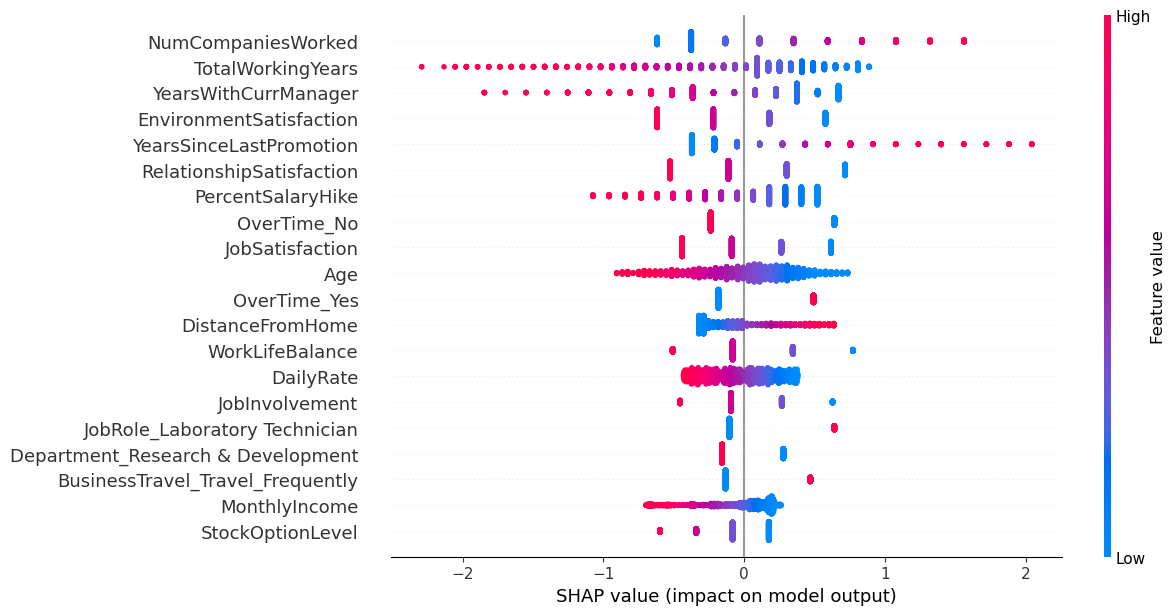

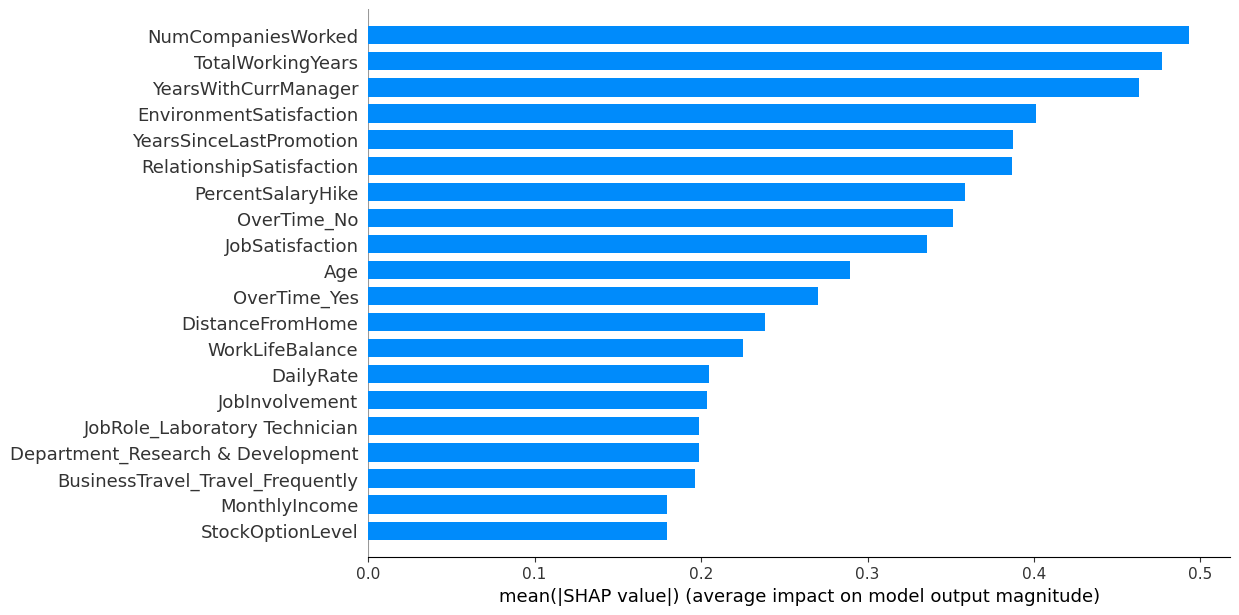

In [4]:
# Summary plot (violin)
summary_plot(
    shap_values,
    X_transformed,
    feature_names=transformed_feature_names,
    show=False
)

# Fix layout
plt.gcf().set_size_inches(12.5, 7.5)          # Adjust size
plt.tight_layout()
plt.subplots_adjust(bottom=0.25)          # Adjust bottom padding
plt.show()

# Summary plot (bar)
summary_plot(
    shap_values,
    X_transformed,
    feature_names=transformed_feature_names,
    plot_type="bar",
    show=False
)

# Fix layout
plt.gcf().set_size_inches(12.5, 7.5)          # Adjust size
plt.tight_layout()
plt.subplots_adjust(bottom=0.25)          # Prevent axis label clipping
plt.show()


## 3. Local Interpretation with SHAP

We use local SHAP explanations to interpret individual predictions for employee attrition. These allow us to identify **why** specific predictions were made, and which features most influenced the decision to classify a sample as high risk (attrition), borderline, or low risk (retention).

---

### 🎯 Objective

- Understand model behavior at the individual prediction level.
- Identify examples close to the classification threshold.
- Use `waterfall` plots for visual clarity and readability.

---

### 🧪 Method Overview

We:
1. Predict probabilities on the transformed test set.
2. Extract 3 meaningful example indices:
   - `i_high`: Highest attrition probability
   - `i_borderline`: Closest to decision threshold
   - `i_low`: Lowest attrition probability
3. Generate waterfall plots to explain these individual predictions.

```python
i_high = np.argmax(y_probs)
i_borderline = np.argmin(np.abs(y_probs - best_threshold))
i_low = np.argmin(y_probs)
```

---

### 📊 Waterfall Plots

We use `shap.plots.waterfall(...)` for each selected sample. These plots show the additive contributions of each feature to the model’s output log-odds (or probability after transformation). The plot begins at the base value and ends at the final model output `f(x)`.

- Red bars = Features pushing the prediction **higher** (toward attrition)
- Blue bars = Features pushing it **lower** (toward retention)

---

### 🔍 Interpretation

- **High-risk case**:
  - Strong positive contributions from `OverTime_Yes`, low `EnvironmentSatisfaction`, low `TotalWorkingYears`, etc.
  - Prediction is far above the threshold → confidently classified as attrition.

- **Borderline case**:
  - Mixed feature contributions.
  - Both positive and negative SHAP values are of similar magnitude.
  - Slight nudge from features like `OverTime_Yes`, `DistanceFromHome` push it above the threshold.

- **Low-risk case**:
  - Dominated by large negative SHAP values.
  - Features like `TotalWorkingYears`, `YearsWithCurrManager`, `NumCompaniesWorked`, and `Age` strongly reduce attrition risk.
  - Model output is far below the threshold → confidently classified as staying.

---

### ⚙️ Visualization Enhancements

```python
fig = plt.figure(figsize=(14, 4), facecolor='white')  # Large size with white background
shap.plots.waterfall(shap_values[i_borderline], max_display=20)
```

This ensures the plot is suitable for viewing, reporting, or exporting.

---

### ✅ Summary

Waterfall plots provide an intuitive breakdown of model predictions at the individual level. They help stakeholders understand:
- Which features matter for a specific person
- Whether the model's reasoning aligns with domain knowledge
- How confident the model is in its prediction

These plots are particularly valuable for edge cases near the decision threshold, where interpretability can guide interventions, auditing, or model improvement.


In [5]:
import numpy as np
import shap

# Predict probabilities using the full pipeline
y_probs = model.predict_proba(X)[:, 1]

# Index of best threshold (already loaded earlier as best_threshold)
# Get examples based on probability zones
i_high = np.argmax(y_probs)  # highest risk prediction
i_borderline = np.argmin(np.abs(y_probs - best_threshold))  # closest to threshold
i_low = np.argmin(y_probs)  # lowest risk prediction

# Convenience printout
print(f"High risk prob: {y_probs[i_high]:.3f}")
print(f"Borderline prob: {y_probs[i_borderline]:.3f}")
print(f"Low risk prob: {y_probs[i_low]:.3f}")

High risk prob: 0.993
Borderline prob: 0.719
Low risk prob: 0.001


Max index: 1469
indices: high=1060, borderline=729, low=1010


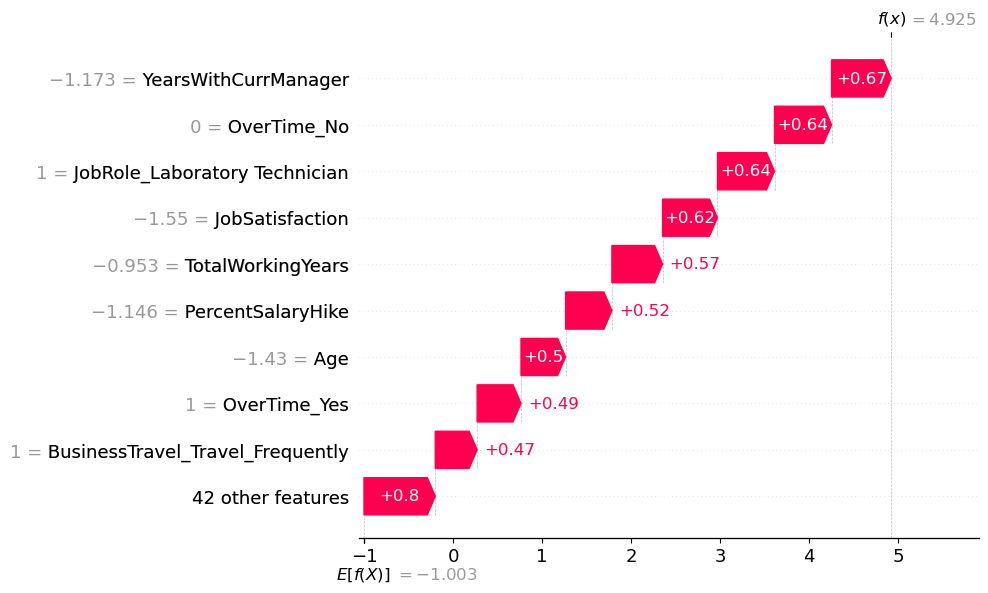

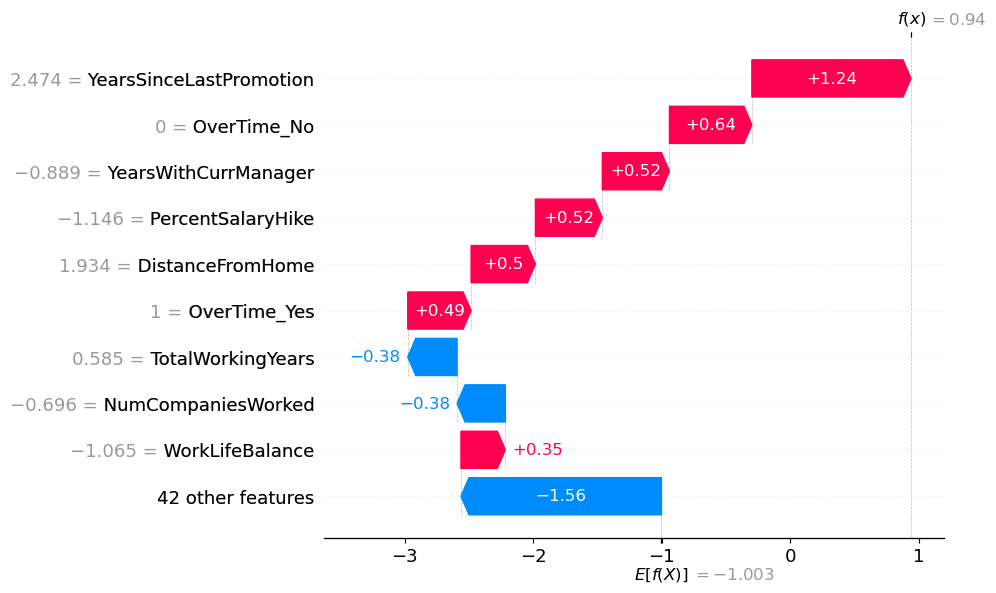

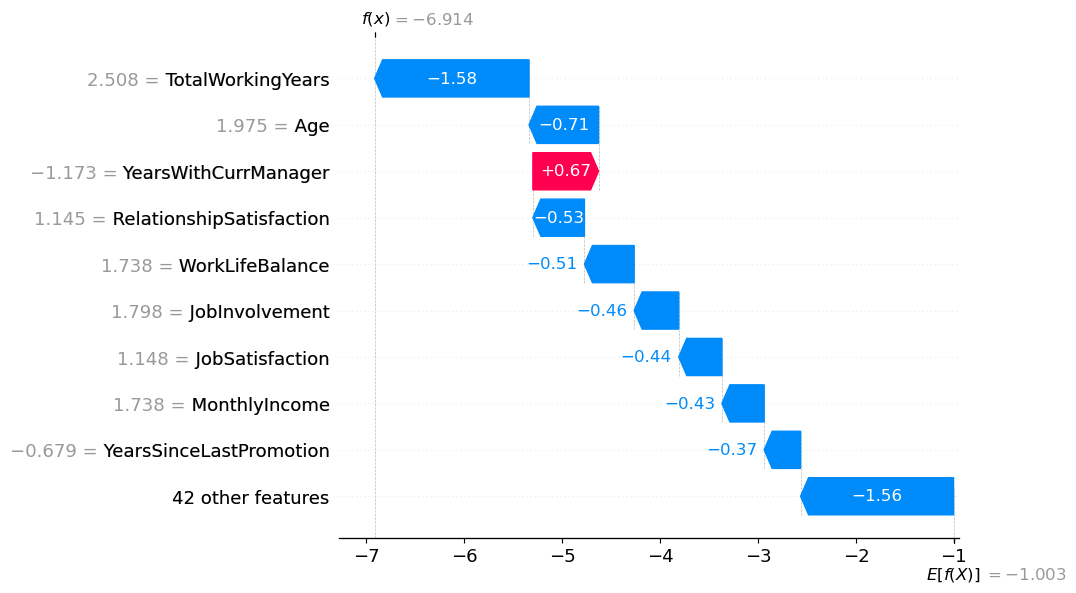

In [6]:
# Get SHAP values and ensure X used here matches shap_values
explainer = LinearExplainer(clf_only, X_transformed, feature_names=transformed_feature_names)
shap_values = explainer(X_transformed)

# Predict using same X_transformed
y_probs = clf_only.predict_proba(X_transformed)[:, 1]  # or use model.predict_proba(X_transformed) if pipeline includes preprocessor

# Get valid indices
i_high = np.argmax(y_probs)
i_borderline = np.argmin(np.abs(y_probs - best_threshold))
i_low = np.argmin(y_probs)

# Confirm that these are in range
print(f"Max index: {X_transformed.shape[0] - 1}")
print(f"indices: high={i_high}, borderline={i_borderline}, low={i_low}")

import shap
import matplotlib.pyplot as plt

# Set SHAP init JS (only needed once per notebook session)
shap.initjs()

# Get matplotlib-based force plot with customized display
fig = plt.figure(figsize=(16, 4), facecolor='white')

# Waterfall plot for high-risk prediction
shap.plots.waterfall(shap_values[i_high])
shap.plots.waterfall(shap_values[i_borderline])
shap.plots.waterfall(shap_values[i_low])

## 4. Threshold Effects on Interpretation

This section explores how adjusting the classification threshold (e.g., from 0.5 to an optimal threshold based on F1 score) impacts both the model's performance and interpretability.

---

### 🎯 Objective

- Compare classification results at default threshold (0.5) vs. optimal threshold.
- Examine samples where predictions change due to threshold shift.
- Use SHAP to explain why the model flips a decision in these borderline cases.

---

### ⚙️ Confusion Matrix Comparison

```python
y_pred_05 = (y_prob > 0.5).astype(int)
y_pred_best = (y_prob > best_threshold).astype(int)
```

Two confusion matrices are displayed side-by-side:
- **Threshold = 0.5**: Standard binary classifier cutoff.
- **Threshold = Best**: Custom threshold maximizing validation F1 score.

This visualizes the trade-off between **false positives** and **false negatives** under different decision boundaries.

---

### 🔄 Analyzing Label Flips

```python
flipped_idx = np.where(y_pred_05 != y_pred_best)[0]
```

This identifies all test set samples whose predicted labels change when switching thresholds.

We randomly sample a few of these and print:

```python
Index: 66, Prob: 0.526, Label_0.5: 1, Label_best: 0
```

This tells us:
- The model **would have predicted attrition** at 0.5
- But under the optimal threshold, it **predicted retention**
- The SHAP waterfall plot explains **why** the output changed

---

### 📊 SHAP Waterfall Plots

We visualize the flipped samples using `shap.plots.waterfall()` to explain their predictions:

- **Red bars**: Features pushing the prediction higher (toward attrition)
- **Blue bars**: Features pushing it lower (toward retention)
- The plots start from the SHAP base value and accumulate feature contributions to reach the model's raw output `f(x)`

Example insights:
- A sample with a probability of 0.59 at threshold 0.5 may flip to class 0 under a 0.72 threshold.
- In that case, `DistanceFromHome`, `EnvironmentSatisfaction`, and `RelationshipSatisfaction` were the top drivers toward attrition, but not strong enough to overcome stabilizing factors like `JobSatisfaction` or `YearsWithCurrManager`.

---

### 🧠 Why This Matters

Threshold tuning isn’t just about performance metrics — it **changes the decision boundary**, which changes:
- **Which predictions flip**
- **Which individuals get flagged**
- **How you explain those flips**

By combining threshold logic with SHAP, we can:
- Identify edge cases that require review
- Justify model decisions under real-world constraints
- Build trust in the model's predictions and rationale

---

### ✅ Summary

This section provides a nuanced view of how **threshold selection** affects both:
1. Model **evaluation metrics**
2. Model **interpretability at the individual level**

Waterfall plots offer transparency into borderline predictions, reinforcing interpretability in operational settings.


c:\Users\justi\Anaconda3\envs\ibm-attrition-env\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


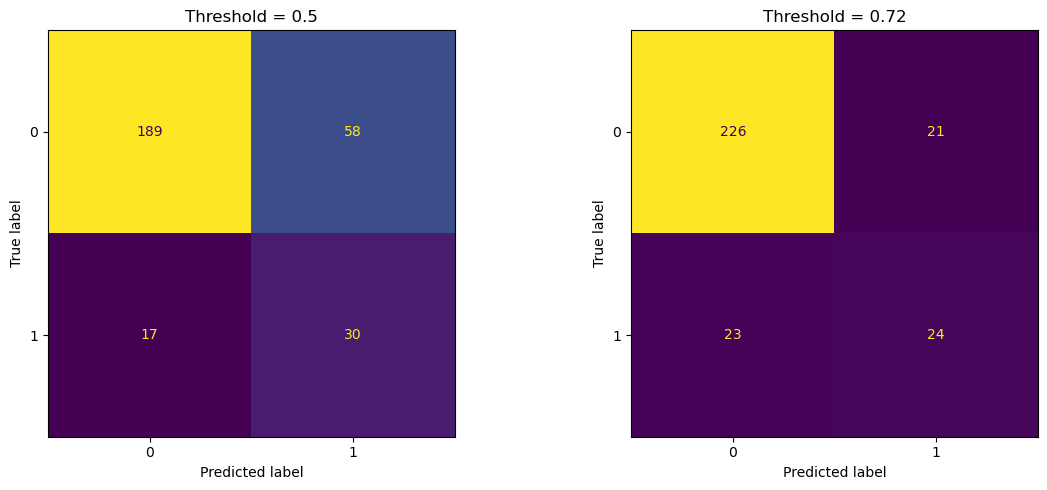

Samples with prediction changes due to threshold shift: 43
Index: 283, Prob: 0.619, Label_0.5: 1, Label_best: 0


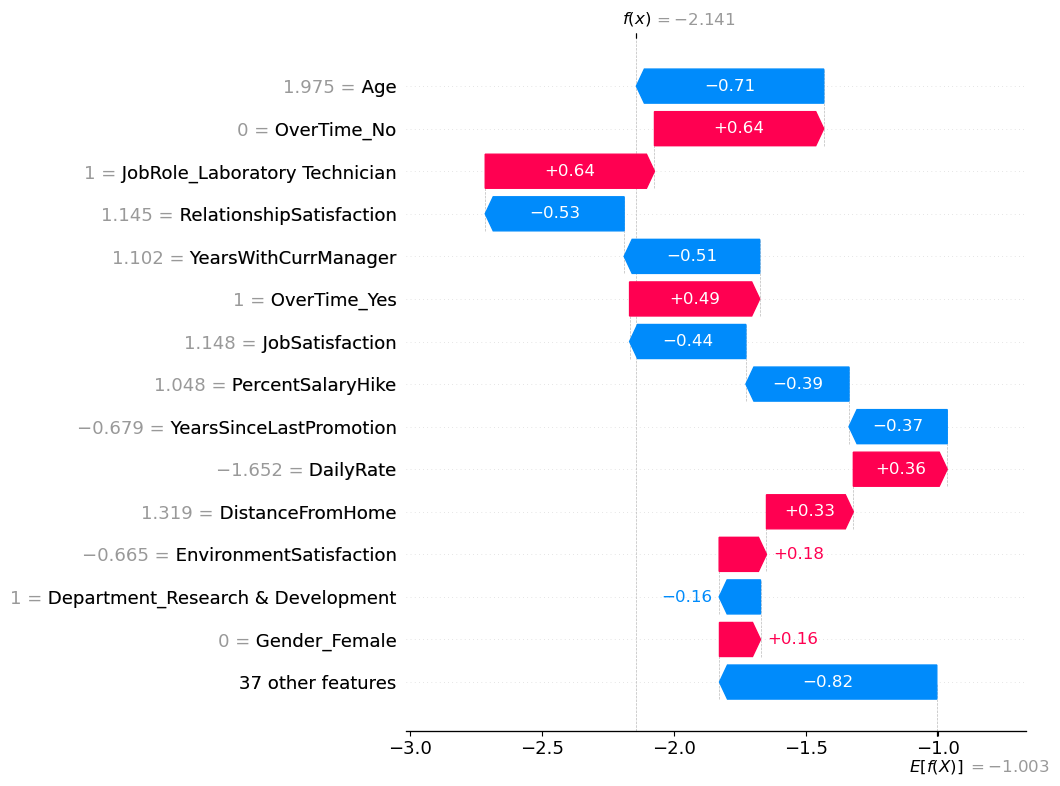

Index: 159, Prob: 0.513, Label_0.5: 1, Label_best: 0


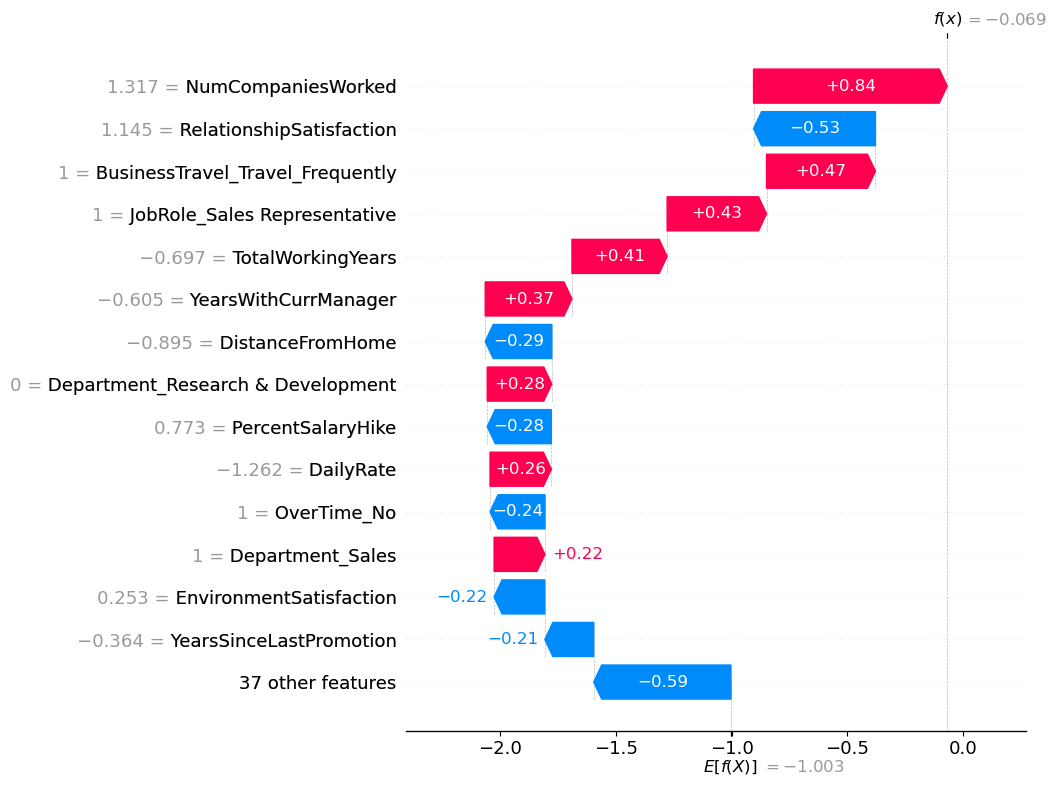

Index: 270, Prob: 0.697, Label_0.5: 1, Label_best: 0


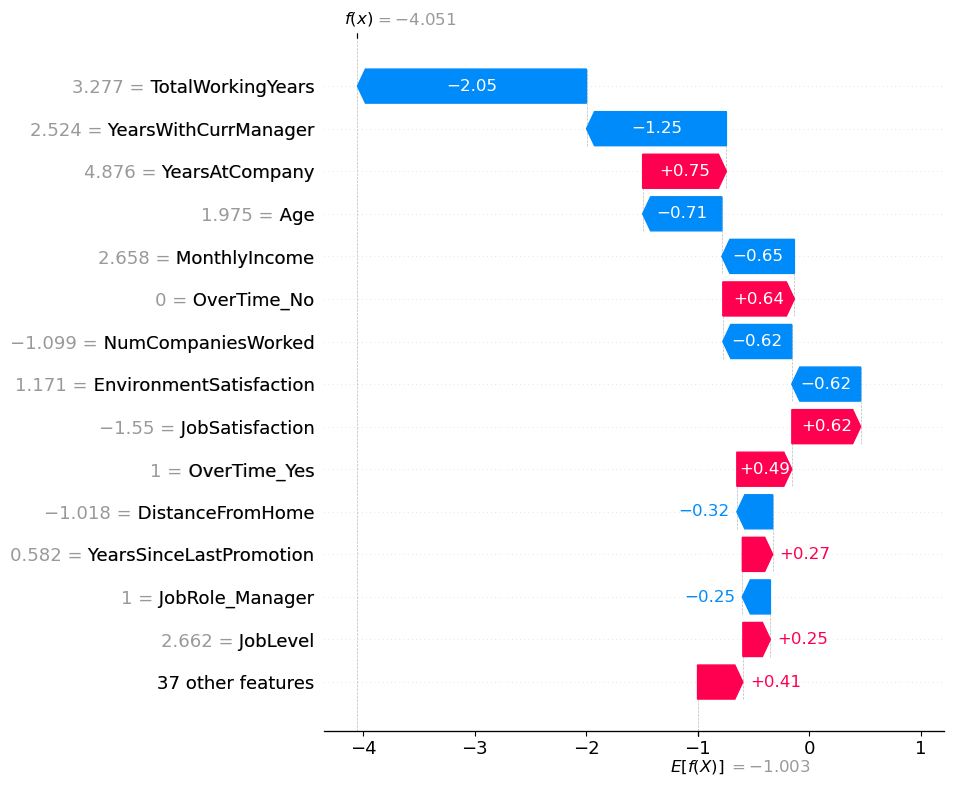

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Extract preprocessing and model steps
preprocessor = model.named_steps['preprocessor']
classifier = model.named_steps['classifier']

# Use original with column names
X_transformed = pd.read_csv('../data/processed/x_test_transformed.csv')

# Predict with threshold 0.5 and best threshold
y_prob = classifier.predict_proba(X_transformed)[:, 1]
y_pred_05 = (y_prob >= 0.5).astype(int)
y_pred_best = (y_prob >= best_threshold).astype(int)

# Plot confusion matrices side-by-side
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
for ax, pred, title in zip(axs, [y_pred_05, y_pred_best], ["Threshold = 0.5", f"Threshold = {best_threshold:.2f}"]):
    cm = confusion_matrix(y, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax, colorbar=False)
    ax.set_title(title)

plt.tight_layout()
plt.show()

# Find samples where predicted label changes between thresholds
flipped_idx = np.where(y_pred_05 != y_pred_best)[0]

# Optional: sample a few from the flipped group
flipped_sample_ids = np.random.choice(flipped_idx, size=min(3, len(flipped_idx)), replace=False)


print(f"Samples with prediction changes due to threshold shift: {len(flipped_idx)}")

# Plot SHAP waterfall plots for flipped samples
for idx in flipped_sample_ids:
    print(f"Index: {idx}, Prob: {y_prob[idx]:.3f}, Label_0.5: {y_pred_05[idx]}, Label_best: {y_pred_best[idx]}")
    shap.plots.waterfall(shap_values[idx], max_display=15)



## ✅ Final Summary: Model Explainability and Interpretation

In this notebook, we explored model explainability using SHAP to understand how and why our attrition prediction model makes its decisions. The analysis focused on both **global** and **local** interpretations, as well as how predictions shift when adjusting the classification threshold.

---

### 🔍 Global Insights

Using SHAP summary plots:
- The most important drivers of attrition were:
  - `NumCompaniesWorked`
  - `TotalWorkingYears`
  - `YearsWithCurrManager`
  - `EnvironmentSatisfaction` and `RelationshipSatisfaction`
- Violin plots revealed that:
  - High values for `NumCompaniesWorked` and low satisfaction scores tended to **increase attrition risk**
  - Stable and longer-tenured employees were **less likely to leave**

These insights support actionable HR strategies — for example, flagging employees with recent job changes or low satisfaction for retention interventions.

---

### 👤 Local Explanations

Using SHAP waterfall plots:
- We examined specific individuals predicted to **leave**, **stay**, or sit **near the decision boundary**
- These plots clearly showed which features pushed predictions in each direction
- Local explanations are critical for transparency, especially for edge cases that may warrant manual review

---

### 🎯 Threshold Effects

We compared the model’s predictions at:
- Default threshold = 0.5
- Optimal threshold (determined by F1 score)

Key takeaways:
- Adjusting the threshold significantly changes the **confusion matrix**, improving balance between false positives and false negatives
- SHAP explanations for flipped predictions clarified the trade-offs involved
- This helps decision-makers choose thresholds aligned with business priorities (e.g., cost of false negatives)

---

### ✅ Conclusion

By combining **model predictions** with **explainability techniques**, we ensure that:
- The model is not a black box
- Stakeholders can trust and act on its outputs
- Critical decisions — such as employee outreach or retention investment — are supported by transparent, data-driven reasoning

This notebook demonstrates the use of SHAP not only as a technical tool, but as a bridge between machine learning performance and human understanding.
